In [ ]:
import os
import pandas as pd
import re

---

In [ ]:
# Directory containing the CSV files
directory = "/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CL/post_processed/attributes/CL"


# Function to transform gauge_id
def transform_gauge_id(gauge_id):
    if gauge_id.startswith("camelscl_"):
        return f"CL_{gauge_id[9:]}"  # Remove 'camelscl_' and add 'CL_'
    return gauge_id


# Iterate through all CSV files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)

        # Read the CSV file
        try:
            df = pd.read_csv(file_path)

            # Check if the file has a gauge_id column
            if "gauge_id" in df.columns:
                # Apply the transformation to the gauge_id column
                df["gauge_id"] = df["gauge_id"].apply(transform_gauge_id)

                # Save the modified file back to the same location
                df.to_csv(file_path, index=False)
                print(f"Processed: {filename}")
            else:
                print(f"Warning: {filename} does not have a gauge_id column")
        except Exception as e:
            print(f"Error processing {filename}: {e}")

print("All files processed.")

In [ ]:
import geopandas as gpd

In [7]:
# Path to the shapefile
path_to_shapefile = "/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/USA/post_processed/shapefiles/USA/USA_basin_shapes.shp"

# Read the shapefile
gdf = gpd.read_file(path_to_shapefile)

# Print the original first few rows
print("Original data:")
print(gdf.head())

# Update the gauge_id field to replace "camels_" with "USA_"
gdf['gauge_id'] = gdf['gauge_id'].str.replace('camels_', 'USA_')

# Print the updated first few rows
print("\nUpdated data:")
print(gdf.head())

# Save the updated shapefile
gdf.to_file(path_to_shapefile)

print(f"\nShapefile updated and saved to {path_to_shapefile}")

Original data:
          gauge_id                                           geometry
0  camels_01013500  MULTIPOLYGON (((-68.06259 47.17901, -68.06028 ...
1  camels_01022500  POLYGON ((-67.97836 44.6131, -67.98141 44.6143...
2  camels_01030500  MULTIPOLYGON (((-68.09162 46.11477, -68.08453 ...
3  camels_01031500  MULTIPOLYGON (((-69.31629 45.15325, -69.32144 ...
4  camels_01047000  POLYGON ((-70.10847 45.21669, -70.10609 45.213...

Updated data:
       gauge_id                                           geometry
0  USA_01013500  MULTIPOLYGON (((-68.06259 47.17901, -68.06028 ...
1  USA_01022500  POLYGON ((-67.97836 44.6131, -67.98141 44.6143...
2  USA_01030500  MULTIPOLYGON (((-68.09162 46.11477, -68.08453 ...
3  USA_01031500  MULTIPOLYGON (((-69.31629 45.15325, -69.32144 ...
4  USA_01047000  POLYGON ((-70.10847 45.21669, -70.10609 45.213...

Shapefile updated and saved to /Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/USA/post_processed/shapefiles/USA/USA_basin_shapes.shp


---

In [ ]:
import sys
from pathlib import Path

sys.path.append(str(Path().absolute().parent))


import pandas as pd
from src.data_models.caravanify import Caravanify, CaravanifyConfig

In [ ]:
config = CaravanifyConfig(
    attributes_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CL/post_processed/attributes",
    timeseries_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CL/post_processed/timeseries/csv",
    gauge_id_prefix="CL",
    use_hydroatlas_attributes=True,
    use_caravan_attributes=True,
    use_other_attributes=True,
)


caravan = Caravanify(config)
ids_for_training = caravan.get_all_gauge_ids()

print(f"Total number of stations: {len(ids_for_training)}")

caravan.load_stations(ids_for_training)


# Get data
ts_data = caravan.get_time_series()
static_data = caravan.get_static_attributes()

In [ ]:
ts_data

In [ ]:
# Check for duplicate gauge IDs
unique_ids = ts_data["gauge_id"].unique()
print(f"Unique gauge IDs: {len(unique_ids)}")

# Check if we have both camelscl_ and CL_ prefixes
prefixes = set([id_[:3] if id_.startswith("CL_") else id_[:9] for id_ in unique_ids])
print(f"Different prefixes found: {prefixes}")

# Count occurrences of each ID
id_counts = ts_data["gauge_id"].value_counts().reset_index()
id_counts.columns = ["gauge_id", "count"]

# Check if same ID appears with different prefixes
id_without_prefix = []
for id_ in unique_ids:
    if id_.startswith("CL_"):
        id_without_prefix.append(id_[3:])
    elif id_.startswith("camelscl_"):
        id_without_prefix.append(id_[9:])
    else:
        id_without_prefix.append(id_)

from collections import Counter

duplicate_base_ids = [
    item for item, count in Counter(id_without_prefix).items() if count > 1
]
print(f"Number of IDs that appear with multiple prefixes: {len(duplicate_base_ids)}")

if duplicate_base_ids:
    print("Examples of duplicate IDs:")
    for base_id in duplicate_base_ids[:5]:  # Show first 5 examples
        matching_ids = [id_ for id_ in unique_ids if id_.endswith(base_id)]
        print(f"Base ID {base_id}: {matching_ids}")

# Check for duplicate dates for the same gauge_id
duplicate_dates = ts_data.duplicated(subset=["gauge_id", "date"], keep=False)
if duplicate_dates.any():
    print(f"\nFound {duplicate_dates.sum()} duplicate (gauge_id, date) combinations")
    print("Sample of duplicates:")
    print(ts_data[duplicate_dates].head(10)[["gauge_id", "date"]])

# Check file count in the directory
import os

timeseries_dir = "/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CL/post_processed/timeseries/csv/CL"
csv_files = [f for f in os.listdir(timeseries_dir) if f.endswith(".csv")]
print(f"\nCSV files in directory: {len(csv_files)}")

# Check if both naming patterns exist in the directory
camelscl_files = [f for f in csv_files if f.startswith("camelscl_")]
cl_files = [f for f in csv_files if f.startswith("CL_")]
print(f"Files with 'camelscl_' prefix: {len(camelscl_files)}")
print(f"Files with 'CL_' prefix: {len(cl_files)}")

In [ ]:
# Check if the gauge_id numbers themselves are unique
base_ids = [id_[3:] for id_ in ts_data['gauge_id'].unique()]
len(base_ids) == len(set(base_ids))  # Should return True if all are unique

# Analyze the distribution of IDs
import re
id_patterns = {}
for id_ in ts_data['gauge_id'].unique():
    # Extract the numeric pattern
    match = re.match(r'CL_(\d+)', id_)
    if match:
        pattern = match.group(1)[:4]  # First 4 digits
        if pattern in id_patterns:
            id_patterns[pattern] += 1
        else:
            id_patterns[pattern] = 1

# Show patterns with most occurrences
import pandas as pd
patterns_df = pd.DataFrame(list(id_patterns.items()), columns=['Pattern', 'Count'])
patterns_df = patterns_df.sort_values('Count', ascending=False)
print(patterns_df.head(10))

# You could also check the attributes file to see if it has the expected number of basins
attributes_path = "/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CL/post_processed/attributes"
import os
attribute_files = os.listdir(attributes_path)
print(f"Attribute files: {attribute_files}")

# If you have access to an official CAMELS-CL basin list, compare against that

Number of basins in shapefile: 505
Number of unique gauge_ids: 505

Total parent basins: 310
Total child basins: 435
True subbasins (no children of their own): 142

Listing true subbasins:
- CL_1001001
- CL_10102001
- CL_10121001
- CL_1021002
- CL_10304001
- CL_10305001
- CL_10322003
- CL_10343001
- CL_10351001
- CL_10362001
- CL_10363002
- CL_10411002
- CL_10431000
- CL_10503001
- CL_10701002
- CL_11020004
- CL_11143002
- CL_11147002
- CL_11307001
- CL_11310002
- CL_11310003
- CL_11314001
- CL_11315001
- CL_11500002
- CL_11504001
- CL_11514001
- CL_11521001
- CL_11532000
- CL_11536001
- CL_11701001
- CL_1201001
- CL_1201005
- CL_12280002
- CL_12284005
- CL_12284006
- CL_12285001
- CL_12286002
- CL_12287001
- CL_12288003
- CL_12288004
- CL_12400003
- CL_1300009
- CL_1610004
- CL_2101001
- CL_2103014
- CL_2105007
- CL_3041001
- CL_3041002
- CL_3050001
- CL_3421001
- CL_4301002
- CL_4302001
- CL_4311001
- CL_4512001
- CL_4520001
- CL_4532001
- CL_4533002
- CL_4712001
- CL_4810006
- CL_51

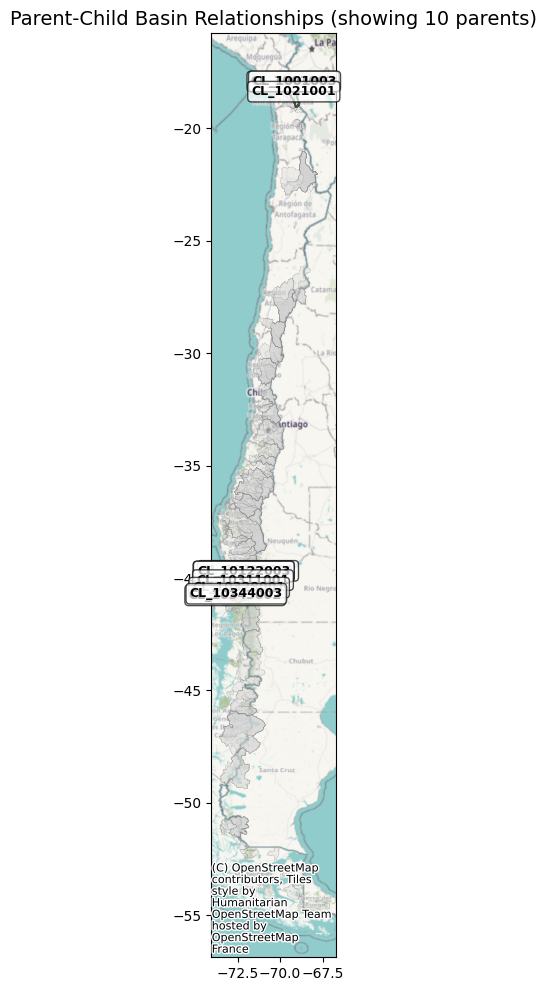

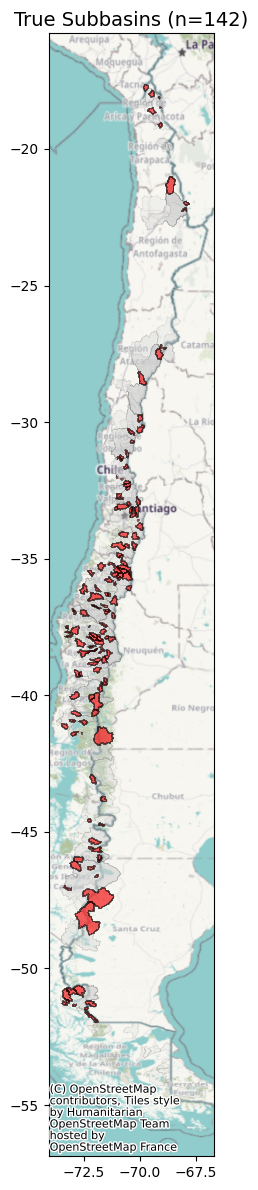

In [4]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx

# Path to the shapefile
path_to_shapefile = "/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CL/post_processed/shapefiles/CL/CL_basin_shapes.shp"

# Read the shapefile
gdf = gpd.read_file(path_to_shapefile)

# Print info
print(f"Number of basins in shapefile: {len(gdf)}")
print(f"Number of unique gauge_ids: {gdf['gauge_id'].nunique()}")

# Create dictionaries to store relationships
parent_to_children = {}
child_to_parents = {}

# Identify containment relationships
for i, basin1 in gdf.iterrows():
    for j, basin2 in gdf.iterrows():
        if i != j:  # Don't compare basin to itself
            # Check if basin1 contains basin2
            if basin1.geometry.contains(basin2.geometry.centroid):
                # Add to parent-child dictionary
                if basin1["gauge_id"] not in parent_to_children:
                    parent_to_children[basin1["gauge_id"]] = []
                parent_to_children[basin1["gauge_id"]].append(basin2["gauge_id"])

                # Add to child-parent dictionary
                if basin2["gauge_id"] not in child_to_parents:
                    child_to_parents[basin2["gauge_id"]] = []
                child_to_parents[basin2["gauge_id"]].append(basin1["gauge_id"])

# Identify true subbasins (child basins that don't contain others)
all_parents = set(parent_to_children.keys())
all_children = set()
for children in parent_to_children.values():
    all_children.update(children)

# True subbasins are children that don't appear as parents
true_subbasins = all_children - all_parents

# Count how many true subbasins each parent contains
parent_subbasin_count = {}
for parent, children in parent_to_children.items():
    # Count children that are true subbasins
    true_children = [child for child in children if child in true_subbasins]
    if true_children:
        parent_subbasin_count[parent] = len(true_children)

# Print results
print(f"\nTotal parent basins: {len(all_parents)}")
print(f"Total child basins: {len(all_children)}")
print(f"True subbasins (no children of their own): {len(true_subbasins)}")

# Print the true subbasins
print("\nListing true subbasins:")
for basin in sorted(list(true_subbasins)):
    print(f"- {basin}")

# Visualize parent-child relationships
# Create figure
fig, ax = plt.subplots(figsize=(12, 12))

# Plot all basins in light gray
gdf.plot(ax=ax, color="lightgray", edgecolor="gray", linewidth=0.3, alpha=0.3)

# Create color map for parents with true subbasins
parents_with_subbasins = list(parent_subbasin_count.keys())
colors = plt.cm.tab20.colors[: len(parents_with_subbasins)]

# Plot each parent-child relationship with distinct colors
for i, parent_id in enumerate(parents_with_subbasins[:10]):  # Limit to 10 for clarity
    # Parent basin with solid color
    parent_basin = gdf[gdf["gauge_id"] == parent_id]
    parent_basin.plot(ax=ax, color=colors[i], edgecolor="black", linewidth=1, alpha=0.6)

    # Child basins that are true subbasins
    children = [
        child for child in parent_to_children[parent_id] if child in true_subbasins
    ]
    if children:
        child_basins = gdf[gdf["gauge_id"].isin(children)]
        child_basins.plot(
            ax=ax,
            color=colors[i],
            edgecolor="red",
            linewidth=0.8,
            alpha=0.3,
            hatch="///",
        )

    # Annotate parent basin
    centroid = parent_basin.geometry.iloc[0].centroid
    ax.annotate(
        f"{parent_id}",
        xy=(centroid.x, centroid.y),
        ha="center",
        fontsize=9,
        fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7),
    )

# Create a separate visualization showing just the subbasins
fig2, ax2 = plt.subplots(figsize=(12, 12))

# Plot all basins in light gray
gdf.plot(ax=ax2, color="lightgray", edgecolor="gray", linewidth=0.3, alpha=0.2)

# Highlight all true subbasins
subbasin_gdf = gdf[gdf["gauge_id"].isin(true_subbasins)]
subbasin_gdf.plot(ax=ax2, color="red", edgecolor="black", linewidth=0.5, alpha=0.6)

# Add title
ax2.set_title(f"True Subbasins (n={len(true_subbasins)})", fontsize=14)

# Try to add basemap for both plots
try:
    ctx.add_basemap(ax, crs=gdf.crs)
    ctx.add_basemap(ax2, crs=gdf.crs)
except Exception as e:
    print(f"Couldn't add basemap: {e}")

# Titles and layout
ax.set_title(f"Parent-Child Basin Relationships (showing 10 parents)", fontsize=14)
plt.tight_layout()
plt.show()
